# BEE2041 Empirical Project Blog

We need a list of all PCCs/force areas. let us scrape that list:


Having established that Selenium is capable of accessing the police.uk website, let's start building an ethical bot! Firstly, we accessed the https://police.uk/robots.txt page and found certain URLs needed to be disallowed. I decided to start by caching the robots.txt file so that my bot could refer to it without sending repeated requests to the site. My bot would then check URLs against those contained in the robot.txt file and would return a "robot.txt error" rather than crawl the forbidden URL:

It is customary to include a specific "user-agent" to identify your bot and make it possible for website administrators to contact you with concerns:

# Data Collection

In [2]:
from selenium.webdriver.chrome.options import Options
def establish_user_agent(user_agent, chromedriver_path):
    chrome_options = Options()
    chrome_options.add_argument(f"user-agent={user_agent}")
    return chrome_options

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
def init_chrome_webdriver(chromedriver_path, chrome_options):
    chrome_options.add_argument("--no-sandbox")  # This parameter helps in avoiding unnecessary crashes.
    chrome_options.add_argument("--disable-gpu")  # Disables GPU hardware acceleration. If software renderer is not in place, then the browser might not launch.
    chrome_options.add_argument("--log-level=3")  # This will only show fatal errors in the console.
    service = Service(executable_path=chromedriver_path)
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

In [4]:
import time
import json
from selenium.webdriver.common.by import By 
def test_user_agent(driver, user_agent):
    driver.get("https://httpbin.org/user-agent")
    time.sleep(5)
    response_data = json.loads(driver.find_element(By.TAG_NAME, "body").text)
    echoed_user_agent = response_data["user-agent"]
    
    if echoed_user_agent != user_agent:
        print("User-Agent does not match the expected value. Quitting...")
        raise Exception("User-Agent does not match the expected value.")

In [5]:
def is_target_disallowed(target, disallowed_dict):
    """
    Check if the target path matches any of the disallowed paths.

    :param target_path: The target path to check
    :param disallowed_paths: A dictionary of disallowed paths from robots.txtf files for each base_url
    :return: True if the target path is disallowed, False otherwise
    """
    # Extract base URL from the target
    parsed_url = urlparse(target)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    
    # Retrieve the list of disallowed patterns for the base URL
    disallowed_patterns = disallowed_dict.get(base_url, [])
    
    # Normalize target path
    target_pattern = f'{parsed_url.path}?{parsed_url.query}'.rstrip("?")
    target_path = target_pattern.rstrip("/")

    for pattern in disallowed_patterns:
        # Normalize disallowed path
        pattern = pattern.rstrip("/")
        
        # Check if the target pattern starts with the disallowed pattern
        if target_path.startswith(pattern):
            return True
        # Checking for file extension disallowance, e.g., '*.aspx$'
        if pattern.endswith('$'):
            base_pattern = pattern[1:-1]
            if target_path.endswith(base_pattern):
                return True

    return False

In [6]:
from urllib.parse import urlparse
import re
def establish_bot_permissions(driver, target, existing_disallowed=None):
    parsed_url = urlparse(target)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    
    # Initialize the dictionary if not provided
    if existing_disallowed is None:
        existing_disallowed = {}
    
    # If the base URL is already in the dictionary, return it
    if base_url in existing_disallowed:
        if is_target_disallowed(target, existing_disallowed):
            print('This URL is not allowed to be crawled in line with robots.txt')
            raise Exception(f"Target path {target} is disallowed.")
        else:
            print(f"{target} is not disallowed")
        return existing_disallowed
    
    # Navigate to relevant robots.txt file
    robots_url = f"{base_url}/robots.txt"
    driver.get(robots_url)
    time.sleep(1)
    
    # Scrape disallowed patterns
    robots_txt_content = driver.find_element(By.TAG_NAME, "body").text
    disallow_pattern = r"Disallow: ([^\n]+)"
    disallowed_paths = re.findall(disallow_pattern, robots_txt_content)
    existing_disallowed[base_url] = disallowed_paths
    
    if is_target_disallowed(target, existing_disallowed):
        print('This URL is not allowed to be crawled in line with robots.txt')
        raise Exception(f"Target path {target} is disallowed.")
    else:
            print(f"{target} is not disallowed")
    return existing_disallowed

In [7]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def get_force_areas(driver, target):
    try:
        driver.get(target)
        all_buttons = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".js-crime-stats-table-toggle"))
        )
    
        if len(all_buttons) > 1:
            toggle_button = all_buttons[1]  # Select the second button
            driver.execute_script("arguments[0].scrollIntoView(true);", toggle_button)
            toggle_button.click()
            time.sleep(2)
        else:
            print("Not enough buttons found.")
    
        tables = driver.find_elements(By.TAG_NAME, 'table')
        table = tables[-1]
        driver.execute_script("arguments[0].scrollIntoView(true);", table)
        rows = table.find_elements(By.TAG_NAME, 'tr')
        force_areas = []
    
        for row in rows:
            cells = row.find_elements(By.TAG_NAME, 'td')
            if cells:
                text = cells[0].text.strip()
                force_areas.append(text)
    except Exception as e:
        print(f"An error occurred while processing: {e}")    
    return force_areas

In [8]:
from selenium.webdriver.common.keys import Keys
def navigate_to_force_area_performance(driver, area, disallowed_patterns, force_area_urls={}):
    try:
        all_search_inputs = WebDriverWait(driver, 10).until(
            EC.visibility_of_all_elements_located((By.CSS_SELECTOR, "input[type='search'], input[name*='search'], input[placeholder*='Search']"))
        )

        # Make sure there are at least two search bars
        if len(all_search_inputs) >= 2:
            search_input = all_search_inputs[1]  # Select the second search input
        else:
            raise Exception("Less than two search inputs found on the page.")
            
        search_input.click()
        # Clear the search field first in case there's any pre-filled text
        search_input.clear()
        # Enter the area name into the search field
        search_input.send_keys(area)
        # Search!
        search_input.send_keys(Keys.ENTER)  # Press Enter directly via Selenium
        
        time.sleep(1)
        #Check if this new page is disallowed
        target = driver.current_url
        disallowed_patterns = establish_bot_permissions(driver,target,disallowed_patterns)

        driver.get(target)
        time.sleep(1)
        print(f"Navigation to the {area} performance page is successful.")

    except Exception as e:
        print(f"An error occurred while navigating to the {area} performance page: {e}")
    return force_area_urls

In [9]:
def get_jurisdictions(driver, area, disallowed_patterns, force_area_jurisdictions={}):
    link = driver.find_elements(By.XPATH, "//a[.//h3[contains(@class, 'c-link-panel_title') and contains(text(), 'Compare your area')]]")
    if len(link)<1:
        print("No data available")
        jurisdictions[area]={}
        return jurisdictions
    link = WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.XPATH, "//a[.//h3[contains(@class, 'c-link-panel_title') and contains(text(), 'Compare your area')]]"))
        )
    target = link.get_attribute('href')
    disallowed_patterns = establish_bot_permissions(driver,target,disallowed_patterns) 
    driver.get(target)
    time.sleep(1)
    all_buttons = driver.find_elements(By.CSS_SELECTOR, ".js-crime-stats-table-toggle")
    if len(all_buttons) > 1:
        toggle_button = all_buttons[1]
        driver.execute_script("arguments[0].scrollIntoView(true);", toggle_button)
        toggle_button.click()
        time.sleep(1)
    else:
        print("Not enough buttons found.")
        jurisdictions[area]={}
        return jurisdictions
    
    tables = driver.find_elements(By.TAG_NAME, 'table')        
    table = tables[2]
    driver.execute_script("arguments[0].scrollIntoView(true);", table)
    rows = table.find_elements(By.TAG_NAME, 'tr')
    force_area_jurisdictions = {}
    
    for row in rows:
        cells = row.find_elements(By.TAG_NAME, 'td')
        if cells:
            text = cells[0].text.strip()
            force_area_jurisdictions[text]=cells[1].text.strip()
    jurisdictions[area] = force_area_jurisdictions
    return jurisdictions

In [10]:
def get_force_area_finances(driver, area, disallowed_patterns,financial_reserves={}):
    navigate_to_force_area_performance(driver, area, disallowed_patterns)
    link = driver.find_elements(By.XPATH, "//a[.//h3[contains(@class, 'c-link-panel_title') and contains(text(), 'Police financial reserves')]]")
    if len(link)<1:
        print("No data available")
        financial_reserves[area]={}
        return financial_reserves
    link = WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.XPATH, "//a[.//h3[contains(@class, 'c-link-panel_title') and contains(text(), 'Police financial reserves')]]"))
        )
    target = link.get_attribute('href')
    disallowed_patterns = establish_bot_permissions(driver,target,disallowed_patterns) 
    driver.get(target)
    time.sleep(1)
    all_buttons = driver.find_elements(By.CSS_SELECTOR, ".js-crime-stats-table-toggle")
    if len(all_buttons) > 1:
        toggle_button = all_buttons[0]
        driver.execute_script("arguments[0].scrollIntoView(true);", toggle_button)
        toggle_button.click()
        time.sleep(1)
    else:
        print("Not enough buttons found.")
        return financial_reserves
    
    tables = driver.find_elements(By.TAG_NAME, 'table')        
    table = tables[-2]
    driver.execute_script("arguments[0].scrollIntoView(true);", table)
    rows = table.find_elements(By.TAG_NAME, 'tr')
    
    for row in rows:
        cells = row.find_elements(By.TAG_NAME, 'td')
        if cells:
            year = cells[0].text.strip()
            financial_reserves[area][year]['General fund']=cells[1].text.strip()
            financial_reserves[area][year]['Earmarked reserves']=cells[2].text.strip()
            financial_reserves[area][year]['Total resource reserves']=cells[3].text.strip()
            financial_reserves[area][year]['Capital reserves']=cells[4].text.strip()
    return financial_reserves
# {force_area:{Mar 2018: {General Fund: 10000, Earmarked Reserves: 10000, Total Resource Reserves: 200000, Capital Reserves: 50000} {Mar 2017:{General Fund....}}}}
# {force_area_keys:{Year_keys:{Fund_type_keys:Values}}}

What follows is the webscraping script- remember to recreate this script's output, you must have first downloaded the relevant chromedriver for your machine from https://googlechromelabs.github.io/chrome-for-testing/#stable, and provide the path to your own version of the chromedriver where prompted in the script. You may also wish to use your own user-agent. It is recommended that your user-agent contains a (+mailto:emailaddress) string so that any crawling of the bot that raises concerns with the service provider can be mediated by them reaching out to you.

In [11]:
# Setup User-Agent
user_agent = "FriendlyUniStudentResearcher/1.0 (+mailto:soc204@exeter.ac.uk)"

#Provide the path to your own version of the chromedriver
chromedriver_path = r"C:\Users\socor\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe"

chrome_options = establish_user_agent(user_agent, chromedriver_path)

# Initialize the WebDriver (assuming Chrome)
driver = init_chrome_webdriver(chromedriver_path,chrome_options)

# Set target URL
target = 'https://www.police.uk/pu/your-area/avon-somerset-constabulary/performance/financial-reserves/'

try:
    # Navigate to a website that echoes back the user-agent
    test_user_agent(driver, user_agent)
        
    # Navigate to target website robots.txt and save the disallowed patterns
    disallowed_patterns = establish_bot_permissions(driver, target)
    
    # Collect the names of Force areas for which data is available
    Force_Areas = get_force_areas(driver, target)
    
    target = 'https://www.police.uk/pu/performance/'
    disallowed_patterns = establish_bot_permissions(driver, target, disallowed_patterns)
    driver.get(target)
    force_area_urls = {}
    jurisdictions = {}
    financial_reserves = {}
    Periods = ('Mar 2011', 'Mar 2012', 'Mar 2013', 'Mar 2014', 'Mar 2015', 'Mar 2016', 'Mar 2017', 'Mar 2018')
    Reserves = ('General fund','Earmarked reserves', 'Total resource reserves', 'Capital reserves')
    for area in Force_Areas:
        period_dict={}
        for period in Periods:
            reserves_dict={}
            for reserve_type in Reserves:
                reserves_dict[reserve_type] = None
                period_dict[period] = reserves_dict 
                financial_reserves[area] = period_dict
    # Target each force area's performance data
    for area in Force_Areas[:-1]:
        force_area_urls = navigate_to_force_area_performance(driver, area, disallowed_patterns, force_area_urls)
        jurisdictions = get_jurisdictions(driver, area, disallowed_patterns)
        #get force area's historical financial reserves
        financial_reserves = get_force_area_finances(driver, area, disallowed_patterns,financial_reserves)
        
        driver.get('https://www.police.uk/pu/performance/')
        time.sleep(2)    

    time.sleep(10)
    
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Close the browser
    driver.quit()

https://www.police.uk/pu/your-area/avon-somerset-constabulary/performance/financial-reserves/ is not disallowed
https://www.police.uk/pu/performance/ is not disallowed
https://www.police.uk/pu/your-area/avon-somerset-constabulary/performance/performance-avon-somerset/?tc=AN004 is not disallowed
Navigation to the Avon and Somerset Constabulary performance page is successful.
https://www.police.uk/pu/your-area/avon-somerset-constabulary/performance/compare-your-area/?tc=AN004 is not disallowed
https://www.police.uk/pu/your-area/avon-somerset-constabulary/performance/performance-avon-somerset/?tc=AN004 is not disallowed
Navigation to the Avon and Somerset Constabulary performance page is successful.
https://www.police.uk/pu/your-area/avon-somerset-constabulary/performance/financial-reserves/?tc=AN004 is not disallowed
https://www.police.uk/pu/your-area/bedfordshire-police/performance/performance-bedfordshire-police/?tc=NU1 is not disallowed
Navigation to the Bedfordshire Police performanc

# Saving Raw Data

In [15]:
file_path = r'C:\Users\socor\Downloads\BEE2041 Empirical Project\data\raw\jurisdictions.txt'
with open(file_path, 'w', encoding='utf-8') as file:
    json.dump(jurisdictions, file, ensure_ascii=False, indent=4)

In [16]:
file_path = r'C:\Users\socor\Downloads\BEE2041 Empirical Project\data\raw\finances.txt'
with open(file_path, 'w', encoding='utf-8') as file:
    json.dump(financial_reserves, file, ensure_ascii=False, indent=4)

# Data Cleaning

The webpage states that data is not available for "City of London Police" force area, so we'll add that force area manually. Similarly, most of the desired data was unavailable for the aggregate "Total England & Wales", so we need to add empty dictionaries to represent missing values in our data for those two "force areas".

In [17]:
Force_Areas.append("City of London Police")

We need to store that data in a pandas series to unlock better functionality. The idea is to get force area level data on financial reserves over the period since records begin and average crime rate for each force area last year.

In [18]:
import pandas as pd
import numpy as np

force_avg_crime_rate = {}
force_jurisdictions = {}
financial_data = {}

# Process average crime rates and jurisdictions
for area in Force_Areas:
    force_avg_crime_rate[area] = jurisdictions.get(area, {}).get('Force average', np.nan)
    force_jurisdictions[area] = [j for j in jurisdictions.get(area, {}) if j != 'Force average'] if area in jurisdictions else np.nan

# Create Pandas Series
Force_Crime_Rates = pd.Series(force_avg_crime_rate, name='Average Crime Rate')
Force_Jurisdictions = pd.Series(force_jurisdictions, name='Jurisdictions')

# Create DataFrame from Series
ForceAreas = pd.DataFrame({'Average Crime Rate': Force_Crime_Rates, 'Jurisdictions': Force_Jurisdictions})

# Process financial reserves
for area in Force_Areas:
    area_data = financial_reserves.get(area, {})
    for period in Periods:
        for fund in Reserves:
            key = f"{period} {fund}"
            value = area_data.get(period, {}).get(fund, np.nan)
            financial_data.setdefault(key, {})[area] = value

# Add financial data to DataFrame
for key, values in financial_data.items():
    ForceAreas[key] = pd.Series(values)

ForceAreas.index.name = 'Force Area'
ForceAreas

,Average Crime Rate,Jurisdictions,Mar 2011 General fund,Mar 2011 Earmarked reserves,Mar 2011 Total resource reserves,Mar 2011 Capital reserves,Mar 2012 General fund,Mar 2012 Earmarked reserves,Mar 2012 Total resource reserves,Mar 2012 Capital reserves,...,Mar 2016 Total resource reserves,Mar 2016 Capital reserves,Mar 2017 General fund,Mar 2017 Earmarked reserves,Mar 2017 Total resource reserves,Mar 2017 Capital reserves,Mar 2018 General fund,Mar 2018 Earmarked reserves,Mar 2018 Total resource reserves,Mar 2018 Capital reserves
Force Area,,,,,,,,,,,,,,,,,,,,,
Avon and Somerset Constabulary,83.24,"[Bath & North East Somerset, South Gloucesters...",£6.7m,£25.6m,£32.2m,£2.1m,£7.5m,£29.6m,£37.1m,£2.4m,...,£39.7m,£11.6m,£10.4m,£26.7m,£37.1m,£7.1m,£10.4m,£25.3m,£35.7m,£0.3m
Bedfordshire Police,73.8,"[Central Bedfordshire, Bedford, Luton]",£2.9m,£6.5m,£9.4m,£0.4m,£2.9m,£6.6m,£9.5m,£0.4m,...,£13.7m,£0.0m,£3.0m,£10.2m,£13.2m,£0.6m,£3.0m,£6.5m,£9.5m,£0.0m
Cambridgeshire Constabulary,84.51,"[East Cambridgeshire, South Cambridgeshire, Hu...",£4.8m,£13.3m,£18.1m,£18.2m,£7.0m,£19.1m,£26.1m,£26.3m,...,£26.6m,£1.7m,£7.2m,£21.3m,£28.5m,£1.2m,£7.2m,£15.3m,£22.5m,£1.9m
Cheshire Constabulary,78.23,"[Cheshire East, Cheshire West, Warrington, Hal...",£7.8m,£10.3m,£18.2m,£2.4m,£5.2m,£10.4m,£15.6m,£4.4m,...,£20.9m,£7.1m,£5.8m,£8.5m,£14.3m,£5.8m,£6.3m,£5.0m,£11.3m,£5.1m
Cleveland Police,144.57,"[Stockton-on-Tees, Redcar & Cleveland, Hartlep...",£7.1m,£6.0m,£13.1m,£0.3m,£8.2m,£6.0m,£14.2m,£0.3m,...,£15.2m,£0.4m,£8.0m,£6.4m,£14.4m,£0.7m,£6.1m,£7.2m,£13.3m,£1.0m
Cumbria Constabulary,74.1,"[South Lakeland, Eden, Copeland, Allerdale, Ba...",£5.1m,£16.8m,£22.0m,£3.3m,£5.1m,£18.9m,£24.1m,£3.3m,...,£23.9m,£6.0m,£3.0m,£21.3m,£24.3m,£6.3m,£3.0m,£19.9m,£22.9m,£7.2m
Derbyshire Constabulary,85.62,"[Derbyshire Dales, North East Derbyshire, Sout...",£3.3m,£31.7m,£35.0m,£6.2m,£3.3m,£36.9m,£40.2m,£6.5m,...,£39.5m,£9.3m,£4.0m,£28.2m,£32.2m,£4.8m,£4.0m,£20.8m,£24.8m,£4.8m
Devon & Cornwall Police,58.6,"[Isles of Scilly, South Devon & Dartmoor, East...",£6.2m,£22.3m,£28.5m,£6.2m,£6.2m,£32.1m,£38.3m,£6.6m,...,£63.7m,£4.7m,£11.9m,£46.9m,£58.8m,£6.1m,£11.7m,£38.4m,£50.0m,£3.8m
Dorset Police,66.92,"[Dorset County, Poole, Bournemouth]",£3.3m,£14.4m,£17.7m,£0.0m,£4.0m,£14.0m,£18.0m,£0.3m,...,£13.0m,£3.9m,£7.4m,£5.7m,£13.1m,£3.9m,£5.0m,£3.8m,£8.8m,£1.2m


In [19]:
def convert_currency(value):
    # Check if the value is a string
    if isinstance(value, str):
        # Remove the pound sign and any other non-numeric characters except for '.'
        value = value.replace('£', '').replace('m', '').strip()
        # Convert to float and then scale if 'm' was in the original string
        try:
            value = float(value)
            value *= 1000000  # Convert millions to a plain numeric value
        except ValueError:
            return None
    return value

In [20]:
def string_to_float(string):
    value = 1
    # Check if the value is a string
    if isinstance(string, str):
        try:
            value = float(string)
        except ValueError:
            return np.nan
        return value

In [21]:
for finances in ForceAreas.iloc[:,2:].columns:
    ForceAreas[finances]=ForceAreas[finances].apply(convert_currency)
ForceAreas

,Average Crime Rate,Jurisdictions,Mar 2011 General fund,Mar 2011 Earmarked reserves,Mar 2011 Total resource reserves,Mar 2011 Capital reserves,Mar 2012 General fund,Mar 2012 Earmarked reserves,Mar 2012 Total resource reserves,Mar 2012 Capital reserves,...,Mar 2016 Total resource reserves,Mar 2016 Capital reserves,Mar 2017 General fund,Mar 2017 Earmarked reserves,Mar 2017 Total resource reserves,Mar 2017 Capital reserves,Mar 2018 General fund,Mar 2018 Earmarked reserves,Mar 2018 Total resource reserves,Mar 2018 Capital reserves
Force Area,,,,,,,,,,,,,,,,,,,,,
Avon and Somerset Constabulary,83.24,"[Bath & North East Somerset, South Gloucesters...",6700000.0,25600000.0,32200000.0,2100000.0,7500000.0,29600000.0,37100000.0,2400000.0,...,39700000.0,11600000.0,10400000.0,26700000.0,37100000.0,7100000.0,10400000.0,25300000.0,35700000.0,300000.0
Bedfordshire Police,73.8,"[Central Bedfordshire, Bedford, Luton]",2900000.0,6500000.0,9400000.0,400000.0,2900000.0,6600000.0,9500000.0,400000.0,...,13700000.0,0.0,3000000.0,10200000.0,13200000.0,600000.0,3000000.0,6500000.0,9500000.0,0.0
Cambridgeshire Constabulary,84.51,"[East Cambridgeshire, South Cambridgeshire, Hu...",4800000.0,13300000.0,18100000.0,18200000.0,7000000.0,19100000.0,26100000.0,26300000.0,...,26600000.0,1700000.0,7200000.0,21300000.0,28500000.0,1200000.0,7200000.0,15300000.0,22500000.0,1900000.0
Cheshire Constabulary,78.23,"[Cheshire East, Cheshire West, Warrington, Hal...",7800000.0,10300000.0,18200000.0,2400000.0,5200000.0,10400000.0,15600000.0,4400000.0,...,20900000.0,7100000.0,5800000.0,8500000.0,14300000.0,5800000.0,6300000.0,5000000.0,11300000.0,5100000.0
Cleveland Police,144.57,"[Stockton-on-Tees, Redcar & Cleveland, Hartlep...",7100000.0,6000000.0,13100000.0,300000.0,8200000.0,6000000.0,14200000.0,300000.0,...,15200000.0,400000.0,8000000.0,6400000.0,14400000.0,700000.0,6100000.0,7200000.0,13300000.0,1000000.0
Cumbria Constabulary,74.1,"[South Lakeland, Eden, Copeland, Allerdale, Ba...",5100000.0,16800000.0,22000000.0,3300000.0,5100000.0,18900000.0,24100000.0,3300000.0,...,23900000.0,6000000.0,3000000.0,21300000.0,24300000.0,6300000.0,3000000.0,19900000.0,22900000.0,7200000.0
Derbyshire Constabulary,85.62,"[Derbyshire Dales, North East Derbyshire, Sout...",3300000.0,31700000.0,35000000.0,6200000.0,3300000.0,36900000.0,40200000.0,6500000.0,...,39500000.0,9300000.0,4000000.0,28200000.0,32200000.0,4800000.0,4000000.0,20800000.0,24800000.0,4800000.0
Devon & Cornwall Police,58.6,"[Isles of Scilly, South Devon & Dartmoor, East...",6200000.0,22300000.0,28500000.0,6200000.0,6200000.0,32100000.0,38300000.0,6600000.0,...,63700000.0,4700000.0,11900000.0,46900000.0,58800000.0,6100000.0,11700000.0,38400000.0,50000000.0,3800000.0
Dorset Police,66.92,"[Dorset County, Poole, Bournemouth]",3300000.0,14400000.0,17700000.0,0.0,4000000.0,14000000.0,18000000.0,300000.0,...,13000000.0,3900000.0,7400000.0,5700000.0,13100000.0,3900000.0,5000000.0,3800000.0,8800000.0,1200000.0


In [22]:
ForceAreas['Average Crime Rate']=ForceAreas['Average Crime Rate'].str.strip().apply(string_to_float)
ForceAreas

,Average Crime Rate,Jurisdictions,Mar 2011 General fund,Mar 2011 Earmarked reserves,Mar 2011 Total resource reserves,Mar 2011 Capital reserves,Mar 2012 General fund,Mar 2012 Earmarked reserves,Mar 2012 Total resource reserves,Mar 2012 Capital reserves,...,Mar 2016 Total resource reserves,Mar 2016 Capital reserves,Mar 2017 General fund,Mar 2017 Earmarked reserves,Mar 2017 Total resource reserves,Mar 2017 Capital reserves,Mar 2018 General fund,Mar 2018 Earmarked reserves,Mar 2018 Total resource reserves,Mar 2018 Capital reserves
Force Area,,,,,,,,,,,,,,,,,,,,,
Avon and Somerset Constabulary,83.24,"[Bath & North East Somerset, South Gloucesters...",6700000.0,25600000.0,32200000.0,2100000.0,7500000.0,29600000.0,37100000.0,2400000.0,...,39700000.0,11600000.0,10400000.0,26700000.0,37100000.0,7100000.0,10400000.0,25300000.0,35700000.0,300000.0
Bedfordshire Police,73.80,"[Central Bedfordshire, Bedford, Luton]",2900000.0,6500000.0,9400000.0,400000.0,2900000.0,6600000.0,9500000.0,400000.0,...,13700000.0,0.0,3000000.0,10200000.0,13200000.0,600000.0,3000000.0,6500000.0,9500000.0,0.0
Cambridgeshire Constabulary,84.51,"[East Cambridgeshire, South Cambridgeshire, Hu...",4800000.0,13300000.0,18100000.0,18200000.0,7000000.0,19100000.0,26100000.0,26300000.0,...,26600000.0,1700000.0,7200000.0,21300000.0,28500000.0,1200000.0,7200000.0,15300000.0,22500000.0,1900000.0
Cheshire Constabulary,78.23,"[Cheshire East, Cheshire West, Warrington, Hal...",7800000.0,10300000.0,18200000.0,2400000.0,5200000.0,10400000.0,15600000.0,4400000.0,...,20900000.0,7100000.0,5800000.0,8500000.0,14300000.0,5800000.0,6300000.0,5000000.0,11300000.0,5100000.0
Cleveland Police,144.57,"[Stockton-on-Tees, Redcar & Cleveland, Hartlep...",7100000.0,6000000.0,13100000.0,300000.0,8200000.0,6000000.0,14200000.0,300000.0,...,15200000.0,400000.0,8000000.0,6400000.0,14400000.0,700000.0,6100000.0,7200000.0,13300000.0,1000000.0
Cumbria Constabulary,74.10,"[South Lakeland, Eden, Copeland, Allerdale, Ba...",5100000.0,16800000.0,22000000.0,3300000.0,5100000.0,18900000.0,24100000.0,3300000.0,...,23900000.0,6000000.0,3000000.0,21300000.0,24300000.0,6300000.0,3000000.0,19900000.0,22900000.0,7200000.0
Derbyshire Constabulary,85.62,"[Derbyshire Dales, North East Derbyshire, Sout...",3300000.0,31700000.0,35000000.0,6200000.0,3300000.0,36900000.0,40200000.0,6500000.0,...,39500000.0,9300000.0,4000000.0,28200000.0,32200000.0,4800000.0,4000000.0,20800000.0,24800000.0,4800000.0
Devon & Cornwall Police,58.60,"[Isles of Scilly, South Devon & Dartmoor, East...",6200000.0,22300000.0,28500000.0,6200000.0,6200000.0,32100000.0,38300000.0,6600000.0,...,63700000.0,4700000.0,11900000.0,46900000.0,58800000.0,6100000.0,11700000.0,38400000.0,50000000.0,3800000.0
Dorset Police,66.92,"[Dorset County, Poole, Bournemouth]",3300000.0,14400000.0,17700000.0,0.0,4000000.0,14000000.0,18000000.0,300000.0,...,13000000.0,3900000.0,7400000.0,5700000.0,13100000.0,3900000.0,5000000.0,3800000.0,8800000.0,1200000.0


In [23]:
for period in Periods:
    newColumn = str(period+' Wealth')
    ForceAreas[newColumn] = ForceAreas[str(period+ ' Total resource reserves')] + ForceAreas[str(period+' Capital reserves')]
ForceAreas['Average Wealth']=ForceAreas.iloc[:,-8:].mean(axis=1)
ForceAreas['Max Wealth']=ForceAreas.iloc[:,-9:-1].max(axis=1)
mean_row=ForceAreas.mean(skipna=True)
ForceAreas.loc['Mean Force Area'] = mean_row
ForceAreas

,Average Crime Rate,Jurisdictions,Mar 2011 General fund,Mar 2011 Earmarked reserves,Mar 2011 Total resource reserves,Mar 2011 Capital reserves,Mar 2012 General fund,Mar 2012 Earmarked reserves,Mar 2012 Total resource reserves,Mar 2012 Capital reserves,...,Mar 2011 Wealth,Mar 2012 Wealth,Mar 2013 Wealth,Mar 2014 Wealth,Mar 2015 Wealth,Mar 2016 Wealth,Mar 2017 Wealth,Mar 2018 Wealth,Average Wealth,Max Wealth
Force Area,,,,,,,,,,,,,,,,,,,,,
Avon and Somerset Constabulary,83.24000,"[Bath & North East Somerset, South Gloucesters...",6.700000e+06,2.560000e+07,3.220000e+07,2.100000e+06,7.500000e+06,2.960000e+07,3.710000e+07,2.400000e+06,...,3.430000e+07,3.950000e+07,4.410000e+07,4.980000e+07,6.020000e+07,5.130000e+07,44200000.0,3.600000e+07,4.492500e+07,6.020000e+07
Bedfordshire Police,73.80000,"[Central Bedfordshire, Bedford, Luton]",2.900000e+06,6.500000e+06,9.400000e+06,4.000000e+05,2.900000e+06,6.600000e+06,9.500000e+06,4.000000e+05,...,9.800000e+06,9.900000e+06,1.320000e+07,1.800000e+07,1.780000e+07,1.370000e+07,13800000.0,9.500000e+06,1.321250e+07,1.800000e+07
Cambridgeshire Constabulary,84.51000,"[East Cambridgeshire, South Cambridgeshire, Hu...",4.800000e+06,1.330000e+07,1.810000e+07,1.820000e+07,7.000000e+06,1.910000e+07,2.610000e+07,2.630000e+07,...,3.630000e+07,5.240000e+07,4.410000e+07,5.250000e+07,2.770000e+07,2.830000e+07,29700000.0,2.440000e+07,3.692500e+07,5.250000e+07
Cheshire Constabulary,78.23000,"[Cheshire East, Cheshire West, Warrington, Hal...",7.800000e+06,1.030000e+07,1.820000e+07,2.400000e+06,5.200000e+06,1.040000e+07,1.560000e+07,4.400000e+06,...,2.060000e+07,2.000000e+07,2.040000e+07,3.120000e+07,3.650000e+07,2.800000e+07,20100000.0,1.640000e+07,2.415000e+07,3.650000e+07
Cleveland Police,144.57000,"[Stockton-on-Tees, Redcar & Cleveland, Hartlep...",7.100000e+06,6.000000e+06,1.310000e+07,3.000000e+05,8.200000e+06,6.000000e+06,1.420000e+07,3.000000e+05,...,1.340000e+07,1.450000e+07,1.110000e+07,1.450000e+07,1.480000e+07,1.560000e+07,15100000.0,1.430000e+07,1.416250e+07,1.560000e+07
Cumbria Constabulary,74.10000,"[South Lakeland, Eden, Copeland, Allerdale, Ba...",5.100000e+06,1.680000e+07,2.200000e+07,3.300000e+06,5.100000e+06,1.890000e+07,2.410000e+07,3.300000e+06,...,2.530000e+07,2.740000e+07,3.170000e+07,3.780000e+07,3.220000e+07,2.990000e+07,30600000.0,3.010000e+07,3.062500e+07,3.780000e+07
Derbyshire Constabulary,85.62000,"[Derbyshire Dales, North East Derbyshire, Sout...",3.300000e+06,3.170000e+07,3.500000e+07,6.200000e+06,3.300000e+06,3.690000e+07,4.020000e+07,6.500000e+06,...,4.120000e+07,4.670000e+07,5.040000e+07,5.170000e+07,5.240000e+07,4.880000e+07,37000000.0,2.960000e+07,4.472500e+07,5.240000e+07
Devon & Cornwall Police,58.60000,"[Isles of Scilly, South Devon & Dartmoor, East...",6.200000e+06,2.230000e+07,2.850000e+07,6.200000e+06,6.200000e+06,3.210000e+07,3.830000e+07,6.600000e+06,...,3.470000e+07,4.490000e+07,5.690000e+07,6.620000e+07,7.010000e+07,6.840000e+07,64900000.0,5.380000e+07,5.748750e+07,7.010000e+07
Dorset Police,66.92000,"[Dorset County, Poole, Bournemouth]",3.300000e+06,1.440000e+07,1.770000e+07,0.000000e+00,4.000000e+06,1.400000e+07,1.800000e+07,3.000000e+05,...,1.770000e+07,1.830000e+07,1.040000e+07,1.470000e+07,1.730000e+07,1.690000e+07,17000000.0,1.000000e+07,1.528750e+07,1.830000e+07


We also want a dataframe that combines jurisdictions with their crime rates (excluding force area averages) so that we can see the worst 5 jurisdictions for crime rate and top 5 jurisdictions for crime rate. From that we need a dataframe linking each jurisdiction a force area so that we can identify which force areas have the most success and whether reserve resources are an effective predictor of reduced crime rate. 

In [24]:
data = []
for area, jurisdiction1 in jurisdictions.items():
    for jurisdiction2, crime_rate in jurisdiction1.items():
        data.append({'Force Area': area, 'Jurisdiction': jurisdiction2, 'Crime Rate': crime_rate})
jurisdiction_df = pd.DataFrame(data)
JurisdictionCrimes = jurisdiction_df[jurisdiction_df['Jurisdiction'] != 'Force average'].copy()
JurisdictionCrimes.set_index('Jurisdiction',inplace=True)
JurisdictionCrimes

,Force Area,Crime Rate
Jurisdiction,,
Bath & North East Somerset,Avon and Somerset Constabulary,64.78
South Gloucestershire,Avon and Somerset Constabulary,65.18
Somerset,Avon and Somerset Constabulary,70.55
North Somerset,Avon and Somerset Constabulary,71.27
Bristol,Avon and Somerset Constabulary,118.47
...,...,...
Wakefield,West Yorkshire Police,138.20
Bradford,West Yorkshire Police,139.58
Leeds,West Yorkshire Police,140.83


In [25]:
JurisdictionCrimes['Crime Rate']=JurisdictionCrimes['Crime Rate'].apply(string_to_float)
JurisdictionCrimes

,Force Area,Crime Rate
Jurisdiction,,
Bath & North East Somerset,Avon and Somerset Constabulary,64.78
South Gloucestershire,Avon and Somerset Constabulary,65.18
Somerset,Avon and Somerset Constabulary,70.55
North Somerset,Avon and Somerset Constabulary,71.27
Bristol,Avon and Somerset Constabulary,118.47
...,...,...
Wakefield,West Yorkshire Police,138.20
Bradford,West Yorkshire Police,139.58
Leeds,West Yorkshire Police,140.83


In [26]:
RankedJurisdictions=JurisdictionCrimes.sort_values('Crime Rate', ascending=True)
RankedJurisdictions.loc['Mean Jurisdiction','Crime Rate']=RankedJurisdictions['Crime Rate'].mean()

In [27]:
Top5Jurisdictions = RankedJurisdictions.iloc[:5,:]
RelativeComparison_Top = Top5Jurisdictions.copy()
RelativeComparison_Top.loc['Mean Jurisdiction'] = RankedJurisdictions.loc['Mean Jurisdiction','Crime Rate']
RelativeComparison_Top.loc['Mean Jurisdiction','Force Area'] = np.nan
RelativeComparison_Top

,Force Area,Crime Rate
Jurisdiction,,
Isles of Scilly,Devon & Cornwall Police,24.110000
South Devon & Dartmoor,Devon & Cornwall Police,41.470000
Broadland,Norfolk Constabulary,41.660000
Suffolk Coastal,Suffolk Constabulary,41.900000
Wealden,Sussex Police,43.220000
Mean Jurisdiction,NaN,82.644888


In [28]:
Bottom5Jurisdictions = RankedJurisdictions.iloc[-6:,:]
RelativeComparison_Bottom = Bottom5Jurisdictions.copy()
RelativeComparison_Bottom.loc['Mean Jurisdiction'] = RankedJurisdictions.loc['Mean Jurisdiction','Crime Rate']
RelativeComparison_Bottom.loc['Mean Jurisdiction','Force Area'] = np.nan
RelativeComparison_Bottom

,Force Area,Crime Rate
Jurisdiction,,
Leeds,West Yorkshire Police,140.830000
Liverpool,Merseyside Police,141.620000
Hartlepool,Cleveland Police,153.470000
Manchester,Greater Manchester Police,181.500000
Middlesbrough,Cleveland Police,183.780000
Mean Jurisdiction,NaN,82.644888


In [29]:
ForceAreasClean = ForceAreas.dropna()
ForceAreasClean

,Average Crime Rate,Jurisdictions,Mar 2011 General fund,Mar 2011 Earmarked reserves,Mar 2011 Total resource reserves,Mar 2011 Capital reserves,Mar 2012 General fund,Mar 2012 Earmarked reserves,Mar 2012 Total resource reserves,Mar 2012 Capital reserves,...,Mar 2011 Wealth,Mar 2012 Wealth,Mar 2013 Wealth,Mar 2014 Wealth,Mar 2015 Wealth,Mar 2016 Wealth,Mar 2017 Wealth,Mar 2018 Wealth,Average Wealth,Max Wealth
Force Area,,,,,,,,,,,,,,,,,,,,,
Avon and Somerset Constabulary,83.24,"[Bath & North East Somerset, South Gloucesters...",6700000.0,25600000.0,32200000.0,2100000.0,7500000.0,29600000.0,37100000.0,2400000.0,...,34300000.0,39500000.0,44100000.0,49800000.0,60200000.0,51300000.0,44200000.0,36000000.0,44925000.0,60200000.0
Bedfordshire Police,73.80,"[Central Bedfordshire, Bedford, Luton]",2900000.0,6500000.0,9400000.0,400000.0,2900000.0,6600000.0,9500000.0,400000.0,...,9800000.0,9900000.0,13200000.0,18000000.0,17800000.0,13700000.0,13800000.0,9500000.0,13212500.0,18000000.0
Cambridgeshire Constabulary,84.51,"[East Cambridgeshire, South Cambridgeshire, Hu...",4800000.0,13300000.0,18100000.0,18200000.0,7000000.0,19100000.0,26100000.0,26300000.0,...,36300000.0,52400000.0,44100000.0,52500000.0,27700000.0,28300000.0,29700000.0,24400000.0,36925000.0,52500000.0
Cheshire Constabulary,78.23,"[Cheshire East, Cheshire West, Warrington, Hal...",7800000.0,10300000.0,18200000.0,2400000.0,5200000.0,10400000.0,15600000.0,4400000.0,...,20600000.0,20000000.0,20400000.0,31200000.0,36500000.0,28000000.0,20100000.0,16400000.0,24150000.0,36500000.0
Cleveland Police,144.57,"[Stockton-on-Tees, Redcar & Cleveland, Hartlep...",7100000.0,6000000.0,13100000.0,300000.0,8200000.0,6000000.0,14200000.0,300000.0,...,13400000.0,14500000.0,11100000.0,14500000.0,14800000.0,15600000.0,15100000.0,14300000.0,14162500.0,15600000.0
Cumbria Constabulary,74.10,"[South Lakeland, Eden, Copeland, Allerdale, Ba...",5100000.0,16800000.0,22000000.0,3300000.0,5100000.0,18900000.0,24100000.0,3300000.0,...,25300000.0,27400000.0,31700000.0,37800000.0,32200000.0,29900000.0,30600000.0,30100000.0,30625000.0,37800000.0
Derbyshire Constabulary,85.62,"[Derbyshire Dales, North East Derbyshire, Sout...",3300000.0,31700000.0,35000000.0,6200000.0,3300000.0,36900000.0,40200000.0,6500000.0,...,41200000.0,46700000.0,50400000.0,51700000.0,52400000.0,48800000.0,37000000.0,29600000.0,44725000.0,52400000.0
Devon & Cornwall Police,58.60,"[Isles of Scilly, South Devon & Dartmoor, East...",6200000.0,22300000.0,28500000.0,6200000.0,6200000.0,32100000.0,38300000.0,6600000.0,...,34700000.0,44900000.0,56900000.0,66200000.0,70100000.0,68400000.0,64900000.0,53800000.0,57487500.0,70100000.0
Dorset Police,66.92,"[Dorset County, Poole, Bournemouth]",3300000.0,14400000.0,17700000.0,0.0,4000000.0,14000000.0,18000000.0,300000.0,...,17700000.0,18300000.0,10400000.0,14700000.0,17300000.0,16900000.0,17000000.0,10000000.0,15287500.0,18300000.0


In [30]:
file_path = r'C:\Users\socor\Downloads\BEE2041 Empirical Project\data\processed\force_areas.csv'
ForceAreas.to_csv(file_path, index=True)

In [31]:
file_path = r'C:\Users\socor\Downloads\BEE2041 Empirical Project\data\processed\jurisdictions.csv'
RankedJurisdictions.to_csv(file_path, index=True)

In [32]:
file_path = r'C:\Users\socor\Downloads\BEE2041 Empirical Project\data\processed\best_jurisdictions.csv'
RelativeComparison_Top.to_csv(file_path, index=True)

In [33]:
file_path = r'C:\Users\socor\Downloads\BEE2041 Empirical Project\data\processed\worst_jurisdictions.csv'
RelativeComparison_Bottom.to_csv(file_path, index=True)

# Data Analysis

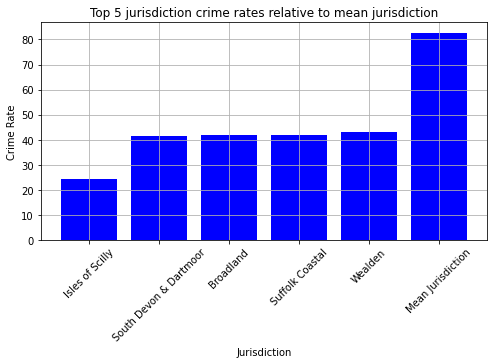

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(RelativeComparison_Top.index, RelativeComparison_Top['Crime Rate'], color = 'blue')
plt.title('Top 5 jurisdiction crime rates relative to mean jurisdiction')
plt.xlabel('Jurisdiction')
plt.ylabel('Crime Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

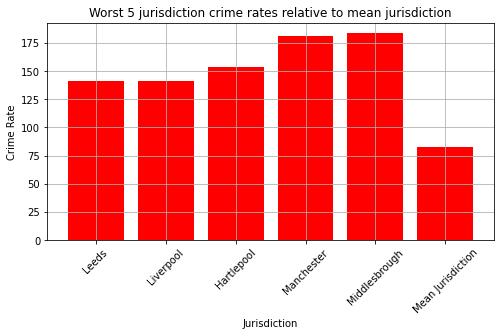

In [28]:
plt.figure(figsize=(8,4))
plt.bar(RelativeComparison_Bottom.index, RelativeComparison_Bottom['Crime Rate'], color = 'red')
plt.title('Worst 5 jurisdiction crime rates relative to mean jurisdiction')
plt.xlabel('Jurisdiction')
plt.ylabel('Crime Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Case Study: Best Force Area

Best Force Area: Devon & Cornwall Police


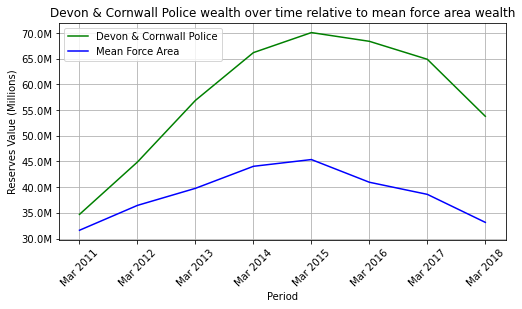

In [29]:
import matplotlib.ticker as ticker
TopForceArea = Top5Jurisdictions['Force Area'].iloc[1]
print('Best Force Area: ' + TopForceArea)
WealthTime = ForceAreas.iloc[:,-10:-2]
TopForceWealthTime=WealthTime.loc[TopForceArea]
x_axis = [i[:8] for i in TopForceWealthTime.index[:]]
plt.figure(figsize=(8,4))
plt.plot(x_axis,TopForceWealthTime, color='green',label = TopForceArea)
plt.plot(x_axis,ForceAreas.loc['Mean Force Area'].iloc[-10:-2],color = 'blue', label = 'Mean Force Area')
plt.xticks(rotation=45)
scale_factor = 1e6
ticks_loc = plt.gca().get_yticks().tolist()
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:0.1f}M'.format(x/scale_factor)))
plt.title(str(TopForceArea + ' wealth over time relative to mean force area wealth'))
plt.xlabel('Period')
plt.ylabel('Reserves Value (Millions)')
plt.legend()
plt.grid(True)
plt.show()

## Case Study: Worst Force Area

Worst Force Area: Cleveland Police


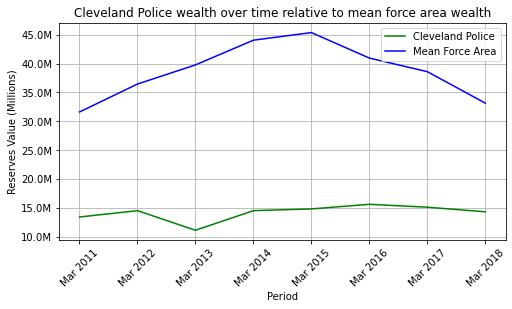

In [30]:
WorstForceArea = Bottom5Jurisdictions['Force Area'].iloc[-2]
print('Worst Force Area: ' + WorstForceArea)
WealthTime = ForceAreas.iloc[:,-10:-2]
WorstForceWealthTime=WealthTime.loc[WorstForceArea]
x_axis = [i[:8] for i in WorstForceWealthTime.index[:]]
plt.figure(figsize=(8,4))
plt.plot(x_axis,WorstForceWealthTime, color='green', label = WorstForceArea)
plt.plot(x_axis,ForceAreas.loc['Mean Force Area'].iloc[-10:-2], color= 'blue', label = 'Mean Force Area')
plt.xticks(rotation=45)
scale_factor = 1e6
ticks_loc = plt.gca().get_yticks().tolist()
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:0.1f}M'.format(x/scale_factor)))
plt.title(str(WorstForceArea + ' wealth over time relative to mean force area wealth'))
plt.xlabel('Period')
plt.ylabel('Reserves Value (Millions)')
plt.legend()
plt.grid(True)
plt.show()

## How well does wealth held in reserves predict a force area's crime rate?

In [43]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor

# Scale the 'Average Wealth' by dividing by 10 million
ForceAreasClean['Scaled Wealth'] = ForceAreasClean['Average Wealth'] / 1000000

ForceAreasClean = ForceAreasClean.dropna(subset=['Average Wealth', 'Average Crime Rate'])

# Define the causal forest model
causal_forest = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    discrete_treatment=False,
    random_state=123
)

# Fit the model
X = pd.DataFrame([0]*len(T), index=T.index)  # No covariates
T = ForceAreasClean['Scaled Wealth']  # Treatment
Y = ForceAreasClean['Average Crime Rate']  # Outcome
causal_forest.fit(Y=Y, T=T, X=X)

# Estimate the causal effect
effects = causal_forest.effect(X)
print("Estimated Causal Effect:\n", effects[0])

Not all column names are strings. Coercing to strings for now.


Estimated Causal Effect:
 0.3218059086371987


While the lack of covariates in my causal forest risks a biased causal estimate, my data appears to predict that if we treat a force area with an additional £1m in reserves then we can expect crime rate to INCREASE by 0.32 crimes per 1,000 population. Without scrutiny, a policy maker could conclude that the way to decrease the crime rate is to cut the amount held in reserves. Perhaps this is because the resources held in reserves are considered more effective in cutting crime rate when the reserves are actually spent/invested, and it is therefore inefficient to hold any reserves. However, in practice it is likely that every force needs some minimum amount in reserves to even exist as a functioning force area. As such, maybe the treatment effect is nonlinear, meaning that the increase in crime rate associated with a reduction in reserves becomes smaller and even negative as the value of amount held in reserves decreases. The next causal forest will check explicitly for non-linearity of the treatment:

In [44]:
T = ForceAreasClean['Scaled Wealth']  # Treatment
Y = ForceAreasClean['Average Crime Rate']  # Outcome

# Creating a squared term of the treatment
T_squared = T ** 2

# Creating the covariate DataFrame
X = pd.DataFrame({
    'T_squared': T_squared
}, index=T.index)

# Define the causal forest model
causal_forest = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    discrete_treatment=False,
    random_state=123
)

# Fit the model with the original treatment and the squared term as a covariate
causal_forest.fit(Y=Y, T=T, X=X)

# Estimate the causal effect
effects = causal_forest.effect(X)
print("Estimated Causal Effects with Squared Term:\n", effects)

Estimated Causal Effects with Squared Term:
 [-0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804
 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804
 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804
 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804
 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804
 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804 -0.09264804
 -0.09264804 -0.09264804 -0.09264804]


In [42]:
# Define the causal forest model
causal_forest = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    discrete_treatment=False,
    random_state=123
)

# Fit the model
X = pd.DataFrame([0]*len(T), index=T.index)  # No covariates
T = ForceAreasClean['Average Crime Rate']  # Treatment
Y = ForceAreasClean['Average Wealth']  # Outcome
causal_forest.fit(Y=Y, T=T, X=X)

# Estimate the causal effect
effects = causal_forest.effect(X)
print("Estimated Causal Effect:\n", effects[0])

Not all column names are strings. Coercing to strings for now.


Estimated Causal Effect:
 425947.56161533063


https://github.com/SOCStudentUoE/BEE2041-Empirical-Assignment